# Import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [3]:
from google.colab import drive
drive.mount('/content/drive')
#MY_PATH = '/content/drive/MyDrive/Brown Spring 2025/EEPS 1340 Machine Learning for the Earth and Environment/EEPS 1340 Project Data/'
MY_PATH = '/content/drive/MyDrive/EEPS 1340 Project/EEPS 1340 Project Data/'

Mounted at /content/drive


# Initial Analysis

In [4]:
df = pd.read_csv(MY_PATH+ 'fire_data.csv')

In [5]:
import folium
from folium.plugins import MarkerCluster

# Folium documentation: https://python-visualization.github.io/folium/latest/getting_started.html

In [6]:
# #remove missing values - location variables cannot be empty
# df = df.dropna(subset=['Lat_DD', 'Long_DD', 'EstTotalAcres'])

# #locate the center of the map by taking the mean of the latitude and longitude values
# center_lat = df['Lat_DD'].mean()
# center_lon = df['Long_DD'].mean()

# m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
# marker_cluster = MarkerCluster().add_to(m)

# # size function, determine radius using a size value (EstTotalAcres) from the dataframe
# def scale_radius(size):
#   return max(2, size**0.5 / 2)

# # loop goes through relevent rows and generates a marker according to fire size on the appropriate location
# # zoomed out, fires are clustered together
# for idx, row in df.iterrows():
#     radius = scale_radius(row['EstTotalAcres'])
#     popup_text = (f"Fire Name: {row['FireName']}<br>"
#                   f"Size: {row['EstTotalAcres']} acres")
#     folium.CircleMarker(
#         location=[row['Lat_DD'], row['Long_DD']],
#         radius=radius,  # Radius in pixels
#         color='red',
#         fill=True,
#         fill_color='red',
#         fill_opacity=0.6,
#         popup=popup_text
#     ).add_to(marker_cluster)

# m.save("fire_size_map_clustered.html")
# m

In [7]:
# #source: https://stackoverflow.com/questions/53565979/export-a-folium-map-as-a-png
# !pip install selenium
# import io
# from PIL import Image
# import selenium

# img_data = m._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# #img.save('image.png')

# from google.colab import files
# #files.download('image.png')

## Data Cleaning

Given the outliers we found when plotting, we will filter our df.

In [8]:
Q1 = df['EstTotalAcres'].quantile(0.25)
Q3 = df['EstTotalAcres'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_nooutliers = df[(df['EstTotalAcres'] >= lower_bound) & (df['EstTotalAcres'] <= upper_bound)]

print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(df_nooutliers)}")

Original dataset size: 23490
Filtered dataset size: 19768


After running these initial analysis, we realized there is a data imbalance we should address before training our model.

In [9]:
len(df_nooutliers[df_nooutliers.HumanOrLightning == 'Lightning'])/len(df_nooutliers)

0.2623431808984217

First, we will undersample!

In [10]:
df_majority = df_nooutliers[df_nooutliers.HumanOrLightning == 'Human']
df_minority = df_nooutliers[df_nooutliers.HumanOrLightning == 'Lightning']

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_balanced_under = pd.concat([df_majority_downsampled, df_minority])

Then, we will oversample!

In [11]:
from sklearn.utils import resample

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

df_balanced_over = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
len(df_nooutliers), len(df_balanced_under), len(df_balanced_over), len(df_majority), len(df_minority), len(df_majority_downsampled)

(19768, 10372, 29152, 14576, 5186, 5186)

Using the three datasets, we have decided to select these columns to run our models on. We will encode the categorical columns.

In [13]:
columns_to_keep = [
    'FireYear', 'Area', 'Size_class', 'EstTotalAcres',
    'Protected_Acres', 'HumanOrLightning', 'CauseBy', 'GeneralCause',
    'Lat_DD', 'Long_DD', 'LatLongDD', 'FO_LandOwnType', 'DistrictName',
    'Ign_DateTime', 'Control_DateTime'
]

df_filtered_over = df_balanced_over[columns_to_keep].copy()
df_filtered_under = df_balanced_under[columns_to_keep].copy()
df_filtered_og = df_nooutliers[columns_to_keep].copy()

In [14]:
size_class_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df_filtered_over['Size_class_encoded'] = df_filtered_over['Size_class'].map(size_class_mapping)
df_filtered_under['Size_class_encoded'] = df_filtered_under['Size_class'].map(size_class_mapping)
df_filtered_og['Size_class_encoded'] = df_filtered_og['Size_class'].map(size_class_mapping)

In [15]:
print("Over-sampled:")
print(df_filtered_over.Size_class_encoded.unique(), df_filtered_over.Size_class.unique())

print("\nUnder-sampled:")
print(df_filtered_under.Size_class_encoded.unique(), df_filtered_under.Size_class.unique())

print("\nOriginal:")
print(df_filtered_og.Size_class_encoded.unique(), df_filtered_og.Size_class.unique())

Over-sampled:
[1 2] ['A' 'B']

Under-sampled:
[2 1] ['B' 'A']

Original:
[2 1] ['B' 'A']


In [16]:
df_filtered_over = pd.get_dummies(
    df_filtered_over,
    columns=['Area', 'FO_LandOwnType', 'DistrictName', 'CauseBy', 'GeneralCause'],
    prefix=['Area', 'LandType', 'DistrictName', 'CauseBy', 'GeneralCause']
)
df_filtered_under = pd.get_dummies(df_filtered_under,
                                   columns=['Area', 'FO_LandOwnType', 'DistrictName', 'CauseBy', 'GeneralCause'],
                                   prefix=['Area', 'LandType', 'DistrictName', 'CauseBy', 'GeneralCause'])
df_filtered_og = pd.get_dummies(df_filtered_og,
                                columns=['Area', 'FO_LandOwnType', 'DistrictName', 'CauseBy', 'GeneralCause'],
                                prefix=['Area', 'LandType', 'DistrictName', 'CauseBy', 'GeneralCause'])

In [17]:
target_mapping = {'Human': 0, 'Lightning': 1}

df_filtered_over['HumanOrLightning_encoded'] = df_filtered_over['HumanOrLightning'].map(target_mapping)
df_filtered_under['HumanOrLightning_encoded'] = df_filtered_under['HumanOrLightning'].map(target_mapping)
df_filtered_og['HumanOrLightning_encoded'] = df_filtered_og['HumanOrLightning'].map(target_mapping)

In [18]:
#Time Columns - Soph
#Ignition Time - convert to month
from datetime import datetime #import date time
from datetime import date #import date
df_filtered_og['Ign_DateTime'] = pd.to_datetime(df_filtered_og['Ign_DateTime'])
df_filtered_over['Ign_DateTime'] = pd.to_datetime(df_filtered_over['Ign_DateTime'])
df_filtered_under['Ign_DateTime'] = pd.to_datetime(df_filtered_under['Ign_DateTime'])
#convert the column to a date time category
df_filtered_og['Ign_Month'] = df_filtered_og['Ign_DateTime'].dt.month
df_filtered_over['Ign_Month'] = df_filtered_over['Ign_DateTime'].dt.month
df_filtered_under['Ign_Month'] = df_filtered_under['Ign_DateTime'].dt.month
#convert the columns to extract only the months (which are floats)
print(df_filtered_over['Ign_Month'])
#print the column

0         7.0
1         7.0
2         6.0
3         4.0
4         5.0
         ... 
29147     7.0
29148    10.0
29149     9.0
29150     8.0
29151     3.0
Name: Ign_Month, Length: 29152, dtype: float64


In [19]:
#Ignition - Control Time - convert to minutes
df_filtered_og['Control_DateTime'] = pd.to_datetime(df_filtered_og['Control_DateTime'])
df_filtered_under['Control_DateTime'] = pd.to_datetime(df_filtered_under['Control_DateTime'])
df_filtered_over['Control_DateTime'] = pd.to_datetime(df_filtered_over['Control_DateTime'])
#convert column to a date time category
df_filtered_og['Time_Difference'] = df_filtered_og['Control_DateTime'] - df_filtered_og['Ign_DateTime']
df_filtered_under['Time_Difference'] = df_filtered_under['Control_DateTime'] - df_filtered_under['Ign_DateTime']
df_filtered_over['Time_Difference'] = df_filtered_over['Control_DateTime'] - df_filtered_over['Ign_DateTime']
#find the time difference between ignition time and control time
df_filtered_og['Control_Minutes'] = df_filtered_og['Time_Difference'].dt.total_seconds()/60
df_filtered_under['Control_Minutes'] = df_filtered_under['Time_Difference'].dt.total_seconds()/60
df_filtered_over['Control_Minutes'] = df_filtered_over['Time_Difference'].dt.total_seconds()/60
#convert the time difference to seconds
print(df_filtered_og['Control_Minutes'])
print(df_filtered_under['Control_Minutes'])
print(df_filtered_over['Control_Minutes'])
#print the column

2        1790.0
4          50.0
5        2895.0
6           6.0
7         330.0
          ...  
23484      45.0
23485     358.0
23486      54.0
23488      92.0
23489      67.0
Name: Control_Minutes, Length: 19768, dtype: float64
20334    29109.0
15694    15000.0
5481        23.0
11182        6.0
19214     5385.0
          ...   
23469      948.0
23470     4702.0
23472     4380.0
23474     1025.0
23489       67.0
Name: Control_Minutes, Length: 10372, dtype: float64
0            0.0
1         1123.0
2         4218.0
3           75.0
4        45930.0
          ...   
29147      361.0
29148       14.0
29149      433.0
29150     1800.0
29151     1621.0
Name: Control_Minutes, Length: 29152, dtype: float64


In [20]:
df_filtered_og['Time_Difference'] = pd.to_timedelta(df_filtered_og['Time_Difference'])
df_filtered_under['Time_Difference'] = pd.to_timedelta(df_filtered_under['Time_Difference'])
df_filtered_over['Time_Difference'] = pd.to_timedelta(df_filtered_over['Time_Difference'])
df_filtered_og['Time_Difference'] = df_filtered_og['Time_Difference'].dt.total_seconds() / 60
df_filtered_under['Time_Difference'] = df_filtered_under['Time_Difference'].dt.total_seconds() / 60
df_filtered_over['Time_Difference'] = df_filtered_over['Time_Difference'].dt.total_seconds()

In [21]:
print("Original:")
print(df_filtered_og.isna().sum().sum())
print(np.round(df_filtered_og.isna().sum().sum()*100/len(df_filtered_og), 2))

print("\nUnder-sampled:")
print(df_filtered_under.isna().sum().sum())
print(np.round(df_filtered_under.isna().sum().sum()*100/len(df_filtered_under), 2))

print("\nOver-sampled:")
print(df_filtered_over.isna().sum().sum())
print(np.round(df_filtered_over.isna().sum().sum()*100/len(df_filtered_over), 2))

Original:
43
0.22

Under-sampled:
10
0.1

Over-sampled:
27
0.09


In [22]:
df_filtered_nan_og = df_filtered_og.dropna()
df_filtered_nan_under = df_filtered_under.dropna()
df_filtered_nan_over = df_filtered_over.dropna()

y_og = df_filtered_nan_og['HumanOrLightning_encoded']
X_og = df_filtered_nan_og.drop(columns=[
    'HumanOrLightning',               # original label
    'HumanOrLightning_encoded',       # target (keep it out of features)
    'LatLongDD',                      # duplicate of Lat + Long
    'Ign_DateTime',                   # raw datetime
    'Control_DateTime',               # raw datetime
    'Size_class',
    'CauseBy_Fisherman', 'CauseBy_Hiker', 'CauseBy_Hunter',
    'CauseBy_Lightning', 'CauseBy_Marijuana Grower', 'CauseBy_Motorist',
       'CauseBy_Other Forest Mgt. Worker', 'CauseBy_Other-Landowner Related',
       'CauseBy_Other-Public', 'CauseBy_Public Utility',
       'CauseBy_Rancher-Farmer', 'CauseBy_Recreationist',
       'CauseBy_Ruralist-Non-Paying', 'CauseBy_Ruralist-Paying',
       'CauseBy_Timber Harvest Worker', 'CauseBy_Transient',
       'GeneralCause_Arson', 'GeneralCause_Debris Burning',
       'GeneralCause_Equipment Use', 'GeneralCause_Juveniles',
       'GeneralCause_Lightning', 'GeneralCause_Miscellaneous',
       'GeneralCause_Railroad', 'GeneralCause_Recreation',
       'GeneralCause_Smoking', 'GeneralCause_Under Invest'


])
y_under = df_filtered_nan_under['HumanOrLightning_encoded']
X_under = df_filtered_nan_under.drop(columns=[
    'HumanOrLightning',               # original label
    'HumanOrLightning_encoded',       # target (keep it out of features)
    'LatLongDD',                      # duplicate of Lat + Long
    'Ign_DateTime',                   # raw datetime
    'Control_DateTime',               # raw datetime
    'Size_class',
    'CauseBy_Fisherman', 'CauseBy_Hiker', 'CauseBy_Hunter',
    'CauseBy_Lightning', 'CauseBy_Marijuana Grower', 'CauseBy_Motorist',
       'CauseBy_Other Forest Mgt. Worker', 'CauseBy_Other-Landowner Related',
       'CauseBy_Other-Public', 'CauseBy_Public Utility',
       'CauseBy_Rancher-Farmer', 'CauseBy_Recreationist',
       'CauseBy_Ruralist-Non-Paying', 'CauseBy_Ruralist-Paying',
       'CauseBy_Timber Harvest Worker', 'CauseBy_Transient',
       'GeneralCause_Arson', 'GeneralCause_Debris Burning',
       'GeneralCause_Equipment Use', 'GeneralCause_Juveniles',
       'GeneralCause_Lightning', 'GeneralCause_Miscellaneous',
       'GeneralCause_Railroad', 'GeneralCause_Recreation',
       'GeneralCause_Smoking', 'GeneralCause_Under Invest'


])
y_over = df_filtered_nan_over['HumanOrLightning_encoded']
X_over = df_filtered_nan_over.drop(columns=[
    'HumanOrLightning',               # original label
    'HumanOrLightning_encoded',       # target (keep it out of features)
    'LatLongDD',                      # duplicate of Lat + Long
    'Ign_DateTime',                   # raw datetime
    'Control_DateTime',               # raw datetime
    'Size_class',
    'CauseBy_Fisherman', 'CauseBy_Hiker', 'CauseBy_Hunter',
    'CauseBy_Lightning', 'CauseBy_Marijuana Grower', 'CauseBy_Motorist',
       'CauseBy_Other Forest Mgt. Worker', 'CauseBy_Other-Landowner Related',
       'CauseBy_Other-Public', 'CauseBy_Public Utility',
       'CauseBy_Rancher-Farmer', 'CauseBy_Recreationist',
       'CauseBy_Ruralist-Non-Paying', 'CauseBy_Ruralist-Paying',
       'CauseBy_Timber Harvest Worker', 'CauseBy_Transient',
       'GeneralCause_Arson', 'GeneralCause_Debris Burning',
       'GeneralCause_Equipment Use', 'GeneralCause_Juveniles',
       'GeneralCause_Lightning', 'GeneralCause_Miscellaneous',
       'GeneralCause_Railroad', 'GeneralCause_Recreation',
       'GeneralCause_Smoking', 'GeneralCause_Under Invest'


])
y_over = df_filtered_nan_over['HumanOrLightning_encoded']

In [23]:
from sklearn.model_selection import train_test_split

X_train_og_, X_test_og, y_train_og_, y_test_og = train_test_split(X_og, y_og, test_size=0.1, random_state=2025)
X_train_og, X_val_og, y_train_og, y_val_og = train_test_split(X_train_og_, y_train_og_, test_size=0.1, random_state=2025)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.1, random_state=2025)
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_under, y_train_under, test_size=0.1, random_state=2025)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.1, random_state=2025)
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(X_train_over, y_train_over, test_size=0.1, random_state=2025)

In [24]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


X_train_og_, X_test_og, y_train_og_, y_test_og = train_test_split(X_og, y_og, test_size=0.1, random_state=2025)
X_train_og, X_val_og, y_train_og, y_val_og = train_test_split(X_train_og_, y_train_og_, test_size=0.1, random_state=2025)

#over
ros = RandomOverSampler(random_state=2025)
X_train_over, y_train_over = ros.fit_resample(X_train_og, y_train_og)

#under
rus = RandomUnderSampler(random_state=2025)
X_train_under, y_train_under = rus.fit_resample(X_train_og, y_train_og)

#val
X_val_over, y_val_over = X_val_og, y_val_og
X_test_over, y_test_over = X_test_og, y_test_og

X_val_under, y_val_under = X_val_og, y_val_og
X_test_under, y_test_under = X_test_og, y_test_og

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [26]:
scaler = StandardScaler()
X_train_og = scaler.fit_transform(X_train_og)
X_test_og = scaler.transform(X_test_og)
lg_reg = LogisticRegression(max_iter=1000)
lg_reg.fit(X_train_og, y_train_og)
lg_reg_pred = lg_reg.predict(X_test_og)
print(classification_report(y_test_og, lg_reg_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1442
         1.0       0.70      0.66      0.68       534

    accuracy                           0.83      1976
   macro avg       0.79      0.78      0.78      1976
weighted avg       0.83      0.83      0.83      1976



## All models

In [27]:
X_train_og_, X_test_og, y_train_og_, y_test_og = train_test_split(X_og, y_og, test_size=0.1, random_state=2025)
X_train_og, X_val_og, y_train_og, y_val_og = train_test_split(X_train_og_, y_train_og_, test_size=0.1, random_state=2025)

In [28]:
param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear', 'saga']
}

param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [3, 5, 10],
    'rf__max_features': ['sqrt', 'log2']
}

param_grid_svm = {
    'svm__C': [0.01, 0.1, 1, 10],
}

param_grid_svmk = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.001]
}

param_grid_knn = {
    'knn__n_neighbors': range(1, 21),
    'knn__metric': ['euclidean', 'manhattan']
}

In [29]:
tscv = TimeSeriesSplit(n_splits=5)
random_state = 2025

In [30]:
pipe_og_lr = ImbPipeline([
    ('lr', LogisticRegression(random_state=random_state))
])
pipe_og_rf = ImbPipeline([
    ('rf', RandomForestClassifier(random_state=random_state))
])
pipe_og_svm = ImbPipeline([
    ('svm', SVC(random_state=random_state))
])
pipe_og_svmk = ImbPipeline([
    ('svm', SVC(kernel='rbf', random_state=random_state))
])
pipe_og_knn = ImbPipeline([
    ('knn', KNeighborsClassifier())
])

In [36]:
# grid lr
grid_search_og_lr = GridSearchCV(pipe_og_lr, param_grid_lr, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_lr.fit(X_train_og, y_train_og)
print("OG Logistic Regression best Parameters:", grid_search_og_lr.best_params_)
best_model_og_lr = grid_search_og_lr.best_estimator_
y_val_pred_og_lr = best_model_og_lr.predict(X_val_og)
print("Logistic Regression Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_lr))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
OG Logistic Regression best Parameters: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1332
         1.0       0.68      0.64      0.66       447

    accuracy                           0.83      1779
   macro avg       0.78      0.77      0.77      1779
weighted avg       0.83      0.83      0.83      1779



In [37]:
# grid rf
grid_search_og_rf = GridSearchCV(pipe_og_rf, param_grid_rf, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_rf.fit(X_train_og, y_train_og)
print("OG Random Forest best Parameters:", grid_search_og_rf.best_params_)
best_model_og_rf = grid_search_og_rf.best_estimator_
y_val_pred_og_rf = best_model_og_rf.predict(X_val_og)
print("Random Forest Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
OG Random Forest best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      1332
         1.0       0.82      0.69      0.75       447

    accuracy                           0.88      1779
   macro avg       0.86      0.82      0.84      1779
weighted avg       0.88      0.88      0.88      1779



In [38]:
# grid svm
grid_search_og_svm = GridSearchCV(pipe_og_svm, param_grid_svm, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_svm.fit(X_train_og, y_train_og)
print("OG SVM best Parameters:", grid_search_og_svm.best_params_)
best_model_og_svm = grid_search_og_svm.best_estimator_
y_val_pred_og_svm = best_model_og_svm.predict(X_val_og)
print("SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_svm))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
OG SVM best Parameters: {'svm__C': 10}
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      1332
         1.0       0.00      0.00      0.00       447

    accuracy                           0.75      1779
   macro avg       0.37      0.50      0.43      1779
weighted avg       0.56      0.75      0.64      1779



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
# grid kernel
grid_search_og_svmk = GridSearchCV(pipe_og_svmk, param_grid_svmk, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_svmk.fit(X_train_og, y_train_og)
print("OG SVM with kernel best Parameters:", grid_search_og_svmk.best_params_)
best_model_og_svmk = grid_search_og_svmk.best_estimator_
y_val_pred_og_svmk = best_model_og_svmk.predict(X_val_og)
print("SVM with kernel Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_svmk))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
OG SVM with kernel best Parameters: {'svm__C': 10, 'svm__gamma': 0.001}
SVM with kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1332
         1.0       0.64      0.55      0.59       447

    accuracy                           0.81      1779
   macro avg       0.75      0.72      0.74      1779
weighted avg       0.80      0.81      0.81      1779



In [40]:
# grid knn
grid_search_og_knn = GridSearchCV(pipe_og_knn, param_grid_knn, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_knn.fit(X_train_og, y_train_og)
print("OG KNN best Parameters:", grid_search_og_knn.best_params_)
best_model_og_knn = grid_search_og_knn.best_estimator_
y_val_pred_og_knn = best_model_og_knn.predict(X_val_og)
print("KNN Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_knn))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
OG KNN best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3}
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      1332
         1.0       0.58      0.58      0.58       447

    accuracy                           0.79      1779
   macro avg       0.72      0.72      0.72      1779
weighted avg       0.79      0.79      0.79      1779



In [41]:
print("\n===== OG DATA (Balanced) =====")
pipe_og_bal_lr = ImbPipeline([
    ('lr', LogisticRegression(random_state=random_state, class_weight='balanced'))
])
pipe_og_bal_rf = ImbPipeline([
    ('rf', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
])
pipe_og_bal_svm = ImbPipeline([
    ('svm', SVC(random_state=random_state, class_weight='balanced'))
])
pipe_og_bal_svmk = ImbPipeline([
    ('svm', SVC(kernel='rbf', random_state=random_state))
])


===== OG DATA (Balanced) =====


In [42]:
grid_search_og_bal_lr = GridSearchCV(pipe_og_bal_lr, param_grid_lr, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_bal_lr.fit(X_train_og, y_train_og)
print("OG Balanced Logistic Regression best Parameters:", grid_search_og_bal_lr.best_params_)
best_model_og_bal_lr = grid_search_og_bal_lr.best_estimator_
y_val_pred_og_bal_lr = best_model_og_bal_lr.predict(X_val_og)
print("Balanced Logistic Regression Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_bal_lr))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
OG Balanced Logistic Regression best Parameters: {'lr__C': 10, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Balanced Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      1332
         1.0       0.58      0.82      0.68       447

    accuracy                           0.80      1779
   macro avg       0.75      0.81      0.77      1779
weighted avg       0.84      0.80      0.81      1779



In [43]:
grid_search_og_bal_rf = GridSearchCV(pipe_og_bal_rf, param_grid_rf, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_bal_rf.fit(X_train_og, y_train_og)
print("OG Balanced Random Forest best Parameters:", grid_search_og_bal_rf.best_params_)
best_model_og_bal_rf = grid_search_og_bal_rf.best_estimator_
y_val_pred_og_bal_rf = best_model_og_bal_rf.predict(X_val_og)
print("Balanced Random Forest Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_bal_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
OG Balanced Random Forest best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      1332
         1.0       0.71      0.83      0.77       447

    accuracy                           0.87      1779
   macro avg       0.83      0.86      0.84      1779
weighted avg       0.88      0.87      0.88      1779



In [44]:
grid_search_og_bal_svm = GridSearchCV(pipe_og_bal_svm, param_grid_svm, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_bal_svm.fit(X_train_og, y_train_og)
print("OG Balanced SVM best Parameters:", grid_search_og_bal_svm.best_params_)
best_model_og_bal_svm = grid_search_og_bal_svm.best_estimator_
y_val_pred_og_bal_svm = best_model_og_bal_svm.predict(X_val_og)
print("Balanced SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_bal_svm))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
OG Balanced SVM best Parameters: {'svm__C': 10}
Balanced SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85      1332
         1.0       0.38      0.05      0.09       447

    accuracy                           0.74      1779
   macro avg       0.57      0.51      0.47      1779
weighted avg       0.66      0.74      0.66      1779



In [45]:
grid_search_og_bal_svmk = GridSearchCV(pipe_og_bal_svmk, param_grid_svmk, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_bal_svmk.fit(X_train_og, y_train_og)
print("OG Balanced SVM best Parameters:", grid_search_og_bal_svmk.best_params_)
best_model_og_bal_svmk = grid_search_og_bal_svmk.best_estimator_
y_val_pred_og_bal_svmk = best_model_og_bal_svmk.predict(X_val_og)
print("Balanced SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_og_bal_svmk))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
OG Balanced SVM best Parameters: {'svm__C': 10, 'svm__gamma': 0.001}
Balanced SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1332
         1.0       0.64      0.55      0.59       447

    accuracy                           0.81      1779
   macro avg       0.75      0.72      0.74      1779
weighted avg       0.80      0.81      0.81      1779



In [46]:
print("\n===== UNDER DATA =====")

under_sampler = RandomUnderSampler(random_state=random_state)
X_train_under, y_train_under = under_sampler.fit_resample(X_train_og, y_train_og)

pipe_under_lr = ImbPipeline([
    ('lr', LogisticRegression(random_state=random_state))
])

pipe_under_rf = ImbPipeline([
    ('rf', RandomForestClassifier(random_state=random_state))
])

pipe_under_svm = ImbPipeline([
    ('svm', SVC(random_state=random_state))
])

pipe_under_svmk = ImbPipeline([
    ('svm', SVC(kernel='rbf', random_state=random_state))
])

pipe_under_knn = ImbPipeline([
    ('knn', KNeighborsClassifier())
])


===== UNDER DATA =====


In [47]:
grid_search_under_lr = GridSearchCV(pipe_under_lr, param_grid_lr, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_lr.fit(X_train_under, y_train_under)
print("Under Logistic Regression best Parameters:", grid_search_under_lr.best_params_)
best_model_under_lr = grid_search_under_lr.best_estimator_
y_val_pred_under_lr = best_model_under_lr.predict(X_val_og)
print("Logistic Regression Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_lr))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
32 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **

Under Logistic Regression best Parameters: {'lr__C': 0.01, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85      1332
         1.0       0.56      0.77      0.65       447

    accuracy                           0.79      1779
   macro avg       0.73      0.78      0.75      1779
weighted avg       0.82      0.79      0.80      1779



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [48]:
grid_search_under_rf = GridSearchCV(pipe_under_rf, param_grid_rf, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_rf.fit(X_train_under, y_train_under)
print("Under Random Forest best Parameters:", grid_search_under_rf.best_params_)
best_model_under_rf = grid_search_under_rf.best_estimator_
y_val_pred_under_rf = best_model_under_rf.predict(X_val_og)
print("Random Forest Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Under Random Forest best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1332
         1.0       0.66      0.87      0.75       447

    accuracy                           0.85      1779
   macro avg       0.80      0.86      0.82      1779
weighted avg       0.88      0.85      0.86      1779



In [49]:
grid_search_under_svm = GridSearchCV(pipe_under_svm, param_grid_svm, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_svm.fit(X_train_under, y_train_under)
print("Under SVM best Parameters:", grid_search_under_svm.best_params_)
best_model_under_svm = grid_search_under_svm.best_estimator_
y_val_pred_under_svm = best_model_under_svm.predict(X_val_og)
print("SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_svm))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
8 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **la

Under SVM best Parameters: {'svm__C': 0.01}
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.01      0.01      1332
         1.0       0.25      0.99      0.40       447

    accuracy                           0.25      1779
   macro avg       0.50      0.50      0.21      1779
weighted avg       0.62      0.25      0.11      1779



In [50]:
grid_search_under_svmk = GridSearchCV(pipe_under_svmk, param_grid_svmk, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_svmk.fit(X_train_under, y_train_under)
print("Under SVM with kernel best Parameters:", grid_search_under_svmk.best_params_)
best_model_under_svmk = grid_search_under_svmk.best_estimator_
y_val_pred_under_svmk = best_model_under_svmk.predict(X_val_og)
print("SVM with kernel Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_svmk))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **

Under SVM with kernel best Parameters: {'svm__C': 0.1, 'svm__gamma': 'scale'}
SVM with kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.01      0.01      1332
         1.0       0.25      0.99      0.40       447

    accuracy                           0.25      1779
   macro avg       0.50      0.50      0.21      1779
weighted avg       0.62      0.25      0.11      1779



In [51]:
grid_search_under_knn = GridSearchCV(pipe_under_knn, param_grid_knn, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_knn.fit(X_train_under, y_train_under)
print("Under KNN best Parameters:", grid_search_under_knn.best_params_)
best_model_under_knn = grid_search_under_knn.best_estimator_
y_val_pred_under_knn = best_model_under_knn.predict(X_val_og)
print("KNN Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_knn))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Under KNN best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1}
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.68      0.77      1332
         1.0       0.44      0.77      0.56       447

    accuracy                           0.70      1779
   macro avg       0.67      0.72      0.67      1779
weighted avg       0.78      0.70      0.72      1779



In [52]:
print("\n===== OVER DATA =====")
over_sampler = RandomOverSampler(random_state=random_state)
X_train_over, y_train_over = over_sampler.fit_resample(X_train_og, y_train_og)

pipe_over_lr = ImbPipeline([
    ('lr', LogisticRegression(random_state=random_state))
])
pipe_over_rf = ImbPipeline([
    ('rf', RandomForestClassifier(random_state=random_state))
])
pipe_over_svm = ImbPipeline([
    ('svm', SVC(random_state=random_state))
])
pipe_over_svmk = ImbPipeline([
    ('svm', SVC(kernel='rbf', random_state=random_state))
])
pipe_over_knn = ImbPipeline([
    ('knn', KNeighborsClassifier())
])


===== OVER DATA =====


In [53]:
grid_search_over_lr = GridSearchCV(pipe_over_lr, param_grid_lr, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_lr.fit(X_train_over, y_train_over)
print("Over Logistic Regression best Parameters:", grid_search_over_lr.best_params_)
best_model_over_lr = grid_search_over_lr.best_estimator_
y_val_pred_over_lr = best_model_over_lr.predict(X_val_og)
print("Logistic Regression Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_lr))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Over Logistic Regression best Parameters: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      1332
         1.0       0.58      0.82      0.68       447

    accuracy                           0.80      1779
   macro avg       0.75      0.81      0.77      1779
weighted avg       0.84      0.80      0.81      1779



In [54]:
grid_search_over_rf = GridSearchCV(pipe_over_rf, param_grid_rf, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_rf.fit(X_train_over, y_train_over)
print("Over Random Forest best Parameters:", grid_search_over_rf.best_params_)
best_model_over_rf = grid_search_over_rf.best_estimator_
y_val_pred_over_rf = best_model_over_rf.predict(X_val_og)
print("Random Forest Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Over Random Forest best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      1332
         1.0       0.70      0.84      0.76       447

    accuracy                           0.87      1779
   macro avg       0.82      0.86      0.84      1779
weighted avg       0.88      0.87      0.87      1779



In [55]:
grid_search_over_svm = GridSearchCV(pipe_over_svm, param_grid_svm, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_svm.fit(X_train_over, y_train_over)
print("Over SVM best Parameters:", grid_search_over_svm.best_params_)
best_model_over_svm = grid_search_over_svm.best_estimator_
y_val_pred_over_svm = best_model_over_svm.predict(X_val_og)
print("SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_svm))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Over SVM best Parameters: {'svm__C': 1}
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.01      0.02      1332
         1.0       0.25      0.99      0.40       447

    accuracy                           0.26      1779
   macro avg       0.49      0.50      0.21      1779
weighted avg       0.61      0.26      0.11      1779



In [56]:
grid_search_over_svmk = GridSearchCV(pipe_over_svmk, param_grid_svmk, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_svmk.fit(X_train_over, y_train_over)
print("Over SVM best Parameters:", grid_search_over_svmk.best_params_)
best_model_over_svmk = grid_search_over_svmk.best_estimator_
y_val_pred_over_svmk = best_model_over_svmk.predict(X_val_og)
print("SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_svmk))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Over SVM best Parameters: {'svm__C': 10, 'svm__gamma': 0.01}
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1332
         1.0       0.55      0.58      0.57       447

    accuracy                           0.78      1779
   macro avg       0.70      0.71      0.71      1779
weighted avg       0.78      0.78      0.78      1779



In [57]:
grid_search_over_knn = GridSearchCV(pipe_over_knn, param_grid_knn, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_knn.fit(X_train_over, y_train_over)
print("Over KNN best Parameters:", grid_search_over_knn.best_params_)
best_model_over_knn = grid_search_over_knn.best_estimator_
y_val_pred_over_knn = best_model_over_knn.predict(X_val_og)
print("KNN Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_knn))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Over KNN best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1}
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      1332
         1.0       0.52      0.57      0.54       447

    accuracy                           0.76      1779
   macro avg       0.68      0.70      0.69      1779
weighted avg       0.77      0.76      0.76      1779



In [53]:
y_test_pred_og_bal_rf = best_model_og_bal_rf.predict(X_test_og)
print("Balanced Random Forest Classification Report -- Test Data:")
print(classification_report(y_test_og, y_test_pred_og_bal_rf))

Balanced Random Forest Classification Report -- Test Data:
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1442
         1.0       0.69      0.89      0.78       534

    accuracy                           0.86      1976
   macro avg       0.82      0.87      0.84      1976
weighted avg       0.88      0.86      0.87      1976



In [41]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE

rus = RandomUnderSampler(sampling_strategy='majority', random_state=2025)
X_train_under, y_train_under = rus.fit_resample(X_train_og, y_train_og)
print("Class distribution after undersampling:", Counter(y_train_under))

smote = SMOTE(sampling_strategy='minority', random_state=2025)
X_train_over, y_train_over = smote.fit_resample(X_train_og, y_train_og)
print("Class distribution after oversampling:", Counter(y_train_over))

pipe_under_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

pipe_over_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

pipe_under_svmk = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

pipe_over_svmk = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

param_grid_svm = {
    'svm__C': [0.01, 0.1, 1, 10]
}

param_grid_svmk = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.001]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

grid_search_under_svm = GridSearchCV(pipe_under_svm, param_grid_svm, cv=cv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_svm.fit(X_train_under, y_train_under)

grid_search_over_svm = GridSearchCV(pipe_over_svm, param_grid_svm, cv=cv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_svm.fit(X_train_over, y_train_over)

grid_search_under_svmk = GridSearchCV(pipe_under_svmk, param_grid_svmk, cv=cv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_svmk.fit(X_train_under, y_train_under)

grid_search_over_svmk = GridSearchCV(pipe_over_svmk, param_grid_svmk, cv=cv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_svmk.fit(X_train_over, y_train_over)

print("Under SVM best Parameters:", grid_search_under_svm.best_params_)
best_model_under_svm = grid_search_under_svm.best_estimator_
y_val_pred_under_svm = best_model_under_svm.predict(X_val_og)
print("SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_svm))

print("Over SVM best Parameters:", grid_search_over_svm.best_params_)
best_model_over_svm = grid_search_over_svm.best_estimator_
y_val_pred_over_svm = best_model_over_svm.predict(X_val_og)
print("SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_svm))

print("Under SVM with kernel best Parameters:", grid_search_under_svmk.best_params_)
best_model_under_svmk = grid_search_under_svmk.best_estimator_
y_val_pred_under_svmk = best_model_under_svmk.predict(X_val_og)
print("SVM with kernel Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_svmk))

print("Over SVM with kernel best Parameters:", grid_search_over_svmk.best_params_)
best_model_over_svmk = grid_search_over_svmk.best_estimator_
y_val_pred_over_svmk = best_model_over_svmk.predict(X_val_og)
print("SVM with kernel Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_svmk))

Class distribution after undersampling: Counter({0.0: 4205, 1.0: 4205})
Class distribution after oversampling: Counter({0.0: 11797, 1.0: 11797})
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Under SVM best Parameters: {'svm__C': 10}
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88      1332
         1.0       0.62      0.82      0.71       447

    accuracy                           0.83      1779
   macro avg       0.78      0.83      0.80      1779
weighted avg       0.86      0.83      0.84      1779

Over SVM best Parameters: {'svm__C': 10}
SVM Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      1332
         1.0       0.77      0.73      0.7

In [44]:
pipe_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=10, max_iter=10000, random_state=42))
])
pipe_linear.fit(X_train_over, y_train_over)
y_pred_linear = pipe_linear.predict(X_test_og)
print("=== Linear SVM ===")
print(classification_report(y_test_og, y_pred_linear))
print(confusion_matrix(y_test_og, y_pred_linear))

pipe_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=10, gamma='scale', kernel='rbf'))
])
pipe_rbf.fit(X_train_over, y_train_over)
y_pred_rbf = pipe_rbf.predict(X_test_og)
print("=== RBF Kernel SVM ===")
print(classification_report(y_test_og, y_pred_rbf))

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== Linear SVM ===
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      1442
         1.0       0.74      0.73      0.74       534

    accuracy                           0.86      1976
   macro avg       0.82      0.82      0.82      1976
weighted avg       0.86      0.86      0.86      1976

[[1307  135]
 [ 142  392]]
=== RBF Kernel SVM ===
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      1442
         1.0       0.74      0.73      0.74       534

    accuracy                           0.86      1976
   macro avg       0.82      0.82      0.82      1976
weighted avg       0.86      0.86      0.86      1976



              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      1442
         1.0       0.74      0.73      0.74       534

    accuracy                           0.86      1976
   macro avg       0.82      0.82      0.82      1976
weighted avg       0.86      0.86      0.86      1976

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      1442
         1.0       0.74      0.73      0.74       534

    accuracy                           0.86      1976
   macro avg       0.82      0.82      0.82      1976
weighted avg       0.86      0.86      0.86      1976



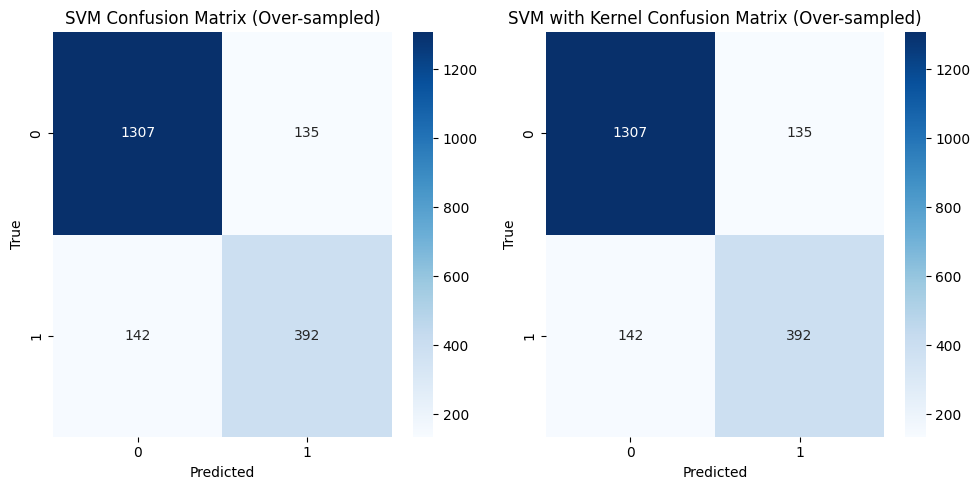

In [42]:
# oversampled trained with test data + confusion matrix
y_test_pred_over_svm = best_model_over_svm.predict(X_test_og)
print(classification_report(y_test_og, y_test_pred_over_svm))
y_val_pred_over_svm = best_model_over_svm.predict(X_test_og)
print("SVM Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_svm))

y_test_pred_over_svmk = best_model_over_svmk.predict(X_test_og)
print(classification_report(y_test_og, y_test_pred_over_svmk))

#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm_over = confusion_matrix(y_test_og, y_test_pred_over_svm)
cm_svmk_over = confusion_matrix(y_test_og, y_test_pred_over_svmk)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(cm_svm_over, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('SVM Confusion Matrix (Over-sampled)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

sns.heatmap(cm_svmk_over, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('SVM with Kernel Confusion Matrix (Over-sampled)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()

In [34]:
# KNN
grid_search_under_knn = GridSearchCV(pipe_og_knn, param_grid_knn, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under_knn.fit(X_train_under, y_train_under)

grid_search_over_knn = GridSearchCV(pipe_og_knn, param_grid_knn, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over_knn.fit(X_train_over, y_train_over)

print("Under KNN best Parameters:", grid_search_under_knn.best_params_)
best_model_under_knn = grid_search_under_knn.best_estimator_
y_val_pred_under_knn = best_model_under_knn.predict(X_val_og)
print("KNN Classification Report:")
print(classification_report(y_val_og, y_val_pred_under_knn))

print("Over KNN best Parameters:", grid_search_over_knn.best_params_)
best_model_over_knn = grid_search_over_knn.best_estimator_
y_val_pred_over_knn = best_model_over_knn.predict(X_val_og)
print("KNN Classification Report:")
print(classification_report(y_val_og, y_val_pred_over_knn))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Under KNN best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1}
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.68      0.77      1332
         1.0       0.44      0.77      0.56       447

    accuracy                           0.70      1779
   macro avg       0.67      0.72      0.67      1779
weighted avg       0.78      0.70      0.72      1779

Over KNN best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1}
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83      1332
         1.0       0.52      0.63      0.57       447

    accuracy                           0.76      1779
   macro avg       0.69      0.72      0.70      1779
weighted avg       0.78      0.76      0.77      1779



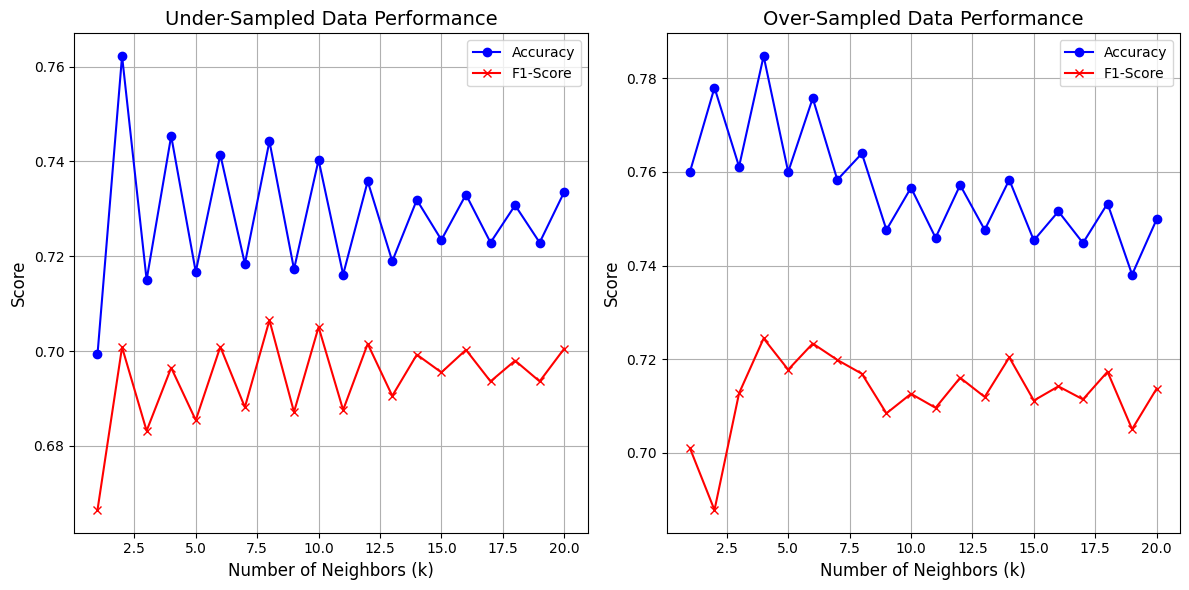

In [36]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

accuracy_scores_under = []
f1_scores_under = []

accuracy_scores_over = []
f1_scores_over = []

k_values = range(1, 21)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_under, y_train_under)
    y_pred = knn.predict(X_val_og)
    accuracy_scores_under.append(accuracy_score(y_val_og, y_pred))
    f1_scores_under.append(f1_score(y_val_og, y_pred, average='macro'))

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_over, y_train_over)
    y_pred = knn.predict(X_val_og)
    accuracy_scores_over.append(accuracy_score(y_val_og, y_pred))
    f1_scores_over.append(f1_score(y_val_og, y_pred, average='macro'))


plt.figure(figsize=(12, 6))

# under-sampled data
plt.subplot(1, 2, 1)
plt.plot(k_values, accuracy_scores_under, label='Accuracy', marker='o', color='b')
plt.plot(k_values, f1_scores_under, label='F1-Score', marker='x', color='r')
plt.title('Under-Sampled Data Performance', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.grid(True)

# over-sampled data
plt.subplot(1, 2, 2)
plt.plot(k_values, accuracy_scores_over, label='Accuracy', marker='o', color='b')
plt.plot(k_values, f1_scores_over, label='F1-Score', marker='x', color='r')
plt.title('Over-Sampled Data Performance', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
# run under sampled with mannhatan and  2 neighbors
knn = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
knn.fit(X_train_under, y_train_under)
y_pred = knn.predict(X_val_og)
print("Validation Scores")
print(classification_report(y_val_og, y_pred))

print("Test Scores")
y_pred = knn.predict(X_test_og)
print(classification_report(y_test_og, y_pred))

# run over sampled with mann and 4 neighbors
knn = KNeighborsClassifier(n_neighbors=4, metric='manhattan')
knn.fit(X_train_over, y_train_over)
y_pred = knn.predict(X_val_og)
print("Validation Scores")
print(classification_report(y_val_og, y_pred))

print("Test Scores")
y_pred = knn.predict(X_test_og)
print(classification_report(y_test_og, y_pred))

Validation Scores
              precision    recall  f1-score   support

         0.0       0.86      0.81      0.84      1332
         1.0       0.52      0.62      0.57       447

    accuracy                           0.76      1779
   macro avg       0.69      0.71      0.70      1779
weighted avg       0.78      0.76      0.77      1779

Test Scores
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      1442
         1.0       0.55      0.62      0.58       534

    accuracy                           0.76      1976
   macro avg       0.70      0.71      0.71      1976
weighted avg       0.77      0.76      0.76      1976

Validation Scores
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      1332
         1.0       0.56      0.63      0.60       447

    accuracy                           0.78      1779
   macro avg       0.72      0.73      0.72      1779
weighted avg       0.79   

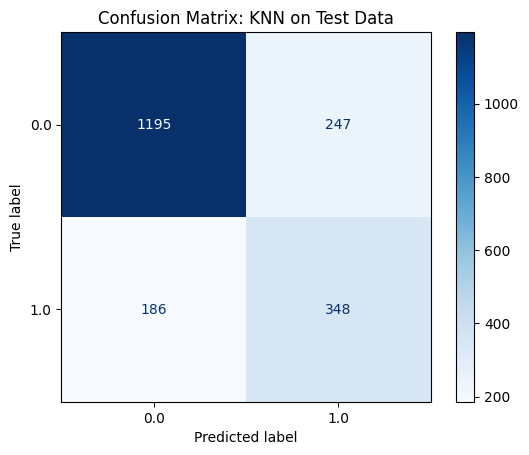

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=4, metric='manhattan')
knn.fit(X_train_over, y_train_over)
y_pred = knn.predict(X_test_og)
cm = confusion_matrix(y_test_og, y_pred)
labels = [0.0, 1.0]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: KNN on Test Data")
plt.show()

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Under KNN best Parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 1}
KNN Classification Report for Under-Sampled Data:
              precision    recall  f1-score   support

         0.0       0.89      0.67      0.77      1332
         1.0       0.44      0.76      0.55       447

    accuracy                           0.69      1779
   macro avg       0.66      0.71      0.66      1779
weighted avg       0.78      0.69      0.71      1779

Over KNN best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 2}
KNN Classification Report for Over-Sampled Data:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.86      1332
         1.0       0.57      0.48      0.52       447

    accuracy                           0.78      1779
   macro avg       0.70      0.68      0.69      1779
weighted avg       0.77      0.78      0.77      1779



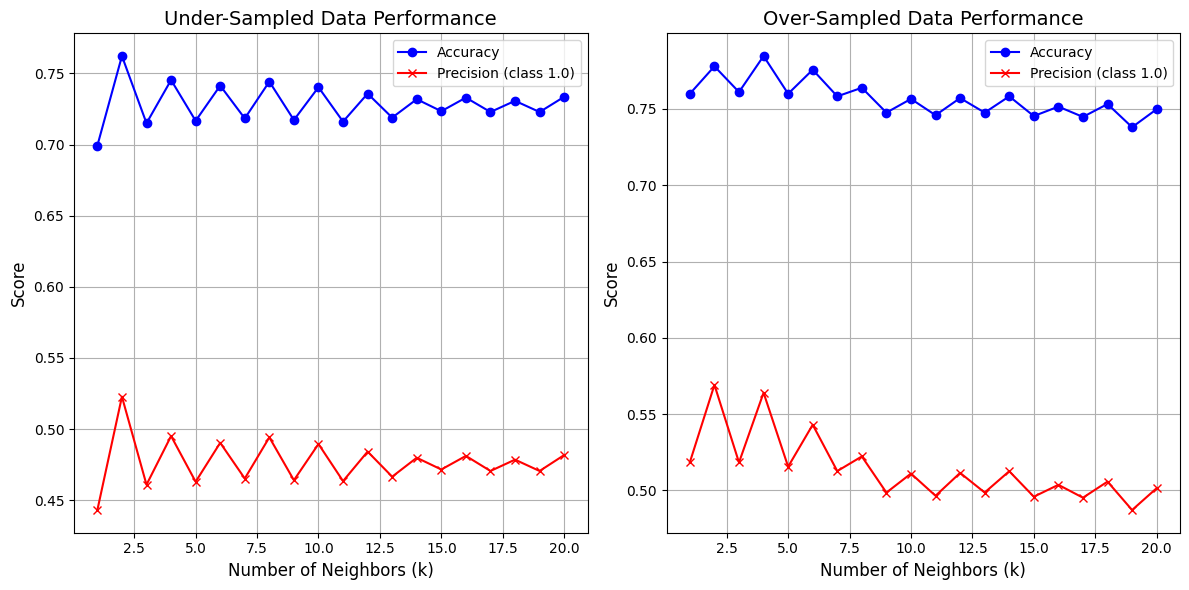

In [39]:
from sklearn.metrics import precision_score, make_scorer
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)

grid_search_under_knn = GridSearchCV(pipe_og_knn, param_grid_knn, cv=tscv, scoring=precision_scorer, verbose=1, n_jobs=-1)
grid_search_under_knn.fit(X_train_under, y_train_under)

grid_search_over_knn = GridSearchCV(pipe_og_knn, param_grid_knn, cv=tscv, scoring=precision_scorer, verbose=1, n_jobs=-1)
grid_search_over_knn.fit(X_train_over, y_train_over)

best_model_under_knn = grid_search_under_knn.best_estimator_
y_val_pred_under_knn = best_model_under_knn.predict(X_val_og)

best_model_over_knn = grid_search_over_knn.best_estimator_
y_val_pred_over_knn = best_model_over_knn.predict(X_val_og)

print("KNN Classification Report for Under-Sampled Data:")
print(classification_report(y_val_og, y_val_pred_under_knn))

# Print the classification report for over-sampled data
print("Over KNN best Parameters:", grid_search_over_knn.best_params_)
print("KNN Classification Report for Over-Sampled Data:")
print(classification_report(y_val_og, y_val_pred_over_knn))


accuracy_scores_under = []
precision_scores_under = []

accuracy_scores_over = []
precision_scores_over = []

k_values = range(1, 21)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_under, y_train_under)
    y_pred = knn.predict(X_val_og)
    accuracy_scores_under.append(accuracy_score(y_val_og, y_pred))
    precision_scores_under.append(precision_score(y_val_og, y_pred, pos_label=1))

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_over, y_train_over)
    y_pred = knn.predict(X_val_og)
    accuracy_scores_over.append(accuracy_score(y_val_og, y_pred))
    precision_scores_over.append(precision_score(y_val_og, y_pred, pos_label=1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracy_scores_under, label='Accuracy', marker='o', color='b')
plt.plot(k_values, precision_scores_under, label='Precision (class 1.0)', marker='x', color='r')
plt.title('Under-Sampled Data Performance', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, accuracy_scores_over, label='Accuracy', marker='o', color='b')
plt.plot(k_values, precision_scores_over, label='Precision (class 1.0)', marker='x', color='r')
plt.title('Over-Sampled Data Performance', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## RandomForest

In [24]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 10],
    'max_features': ['sqrt', 'log2']
}

tscv = TimeSeriesSplit(n_splits=5)

In [25]:
print("\n===== OG DATA =====")
rf_og = RandomForestClassifier(random_state=2025)
grid_search_og = GridSearchCV(estimator=rf_og,
                              param_grid=param_grid,
                              cv=tscv,
                              scoring='f1_macro',
                              verbose=1,
                              n_jobs=-1)
grid_search_og.fit(X_train_og, y_train_og)

print("OG best Parameters:", grid_search_og.best_params_)
best_model_og = grid_search_og.best_estimator_
y_val_pred_og = best_model_og.predict(X_val_og)
print(classification_report(y_val_og, y_val_pred_og))

print("\n===== UNDER DATA =====")
rf_under = RandomForestClassifier(random_state=2025)
grid_search_under = GridSearchCV(estimator=rf_under,
                                 param_grid=param_grid,
                                 cv=tscv,
                                 scoring='f1_macro',
                                 verbose=1,
                                 n_jobs=-1)
grid_search_under.fit(X_train_under, y_train_under)

print("Under best Parameters:", grid_search_under.best_params_)
best_model_under = grid_search_under.best_estimator_
y_val_pred_under = best_model_under.predict(X_val_under)
print(classification_report(y_val_under, y_val_pred_under))

print("\n===== OVER DATA =====")
rf_over = RandomForestClassifier(random_state=2025)
grid_search_over = GridSearchCV(estimator=rf_over,
                                param_grid=param_grid,
                                cv=tscv,
                                scoring='f1_macro',
                                verbose=1,
                                n_jobs=-1)
grid_search_over.fit(X_train_over, y_train_over)

print("Over best Parameters:", grid_search_over.best_params_)
best_model_over = grid_search_over.best_estimator_
y_val_pred_over = best_model_over.predict(X_val_over)
print(classification_report(y_val_over, y_val_pred_over))

print("\n===== OG DATA (Balanced) =====")
rf_og_bal = RandomForestClassifier(random_state=2025, class_weight='balanced')
grid_search_og_bal = GridSearchCV(estimator=rf_og_bal,
                                  param_grid=param_grid,
                                  cv=tscv,
                                  scoring='f1_macro',
                                  verbose=1,
                                  n_jobs=-1)
grid_search_og_bal.fit(X_train_og, y_train_og)

print("OG Balanced best Parameters:", grid_search_og_bal.best_params_)
best_model_og_bal = grid_search_og_bal.best_estimator_
y_val_pred_og_bal = best_model_og_bal.predict(X_val_og)
print(classification_report(y_val_og, y_val_pred_og_bal))


===== OG DATA =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
OG best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      1332
         1.0       0.82      0.69      0.75       447

    accuracy                           0.88      1779
   macro avg       0.86      0.82      0.84      1779
weighted avg       0.88      0.88      0.88      1779


===== UNDER DATA =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Under best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1332
         1.0       0.66      0.87      0.75       447

    accuracy                           0.85      1779
   macro avg       0.80      0.86      0.82      1779
weighted avg       0.88      0.85      0.86      1779


===== OVE

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

X_train_og_, X_test_og, y_train_og_, y_test_og = train_test_split(X_og, y_og, test_size=0.1, random_state=2025)
X_train_og, X_val_og, y_train_og, y_val_og = train_test_split(X_train_og_, y_train_og_, test_size=0.1, random_state=2025)

param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [3, 5, 10],
    'rf__max_features': ['sqrt', 'log2']
}
tscv = TimeSeriesSplit(n_splits=5)
random_state = 2025

print("\n===== OG DATA =====")
pipe_og = ImbPipeline([
    ('rf', RandomForestClassifier(random_state=random_state))
])
grid_search_og = GridSearchCV(pipe_og, param_grid, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og.fit(X_train_og, y_train_og)

print("OG best Parameters:", grid_search_og.best_params_)
best_model_og = grid_search_og.best_estimator_
y_val_pred_og = best_model_og.predict(X_val_og)
print(classification_report(y_val_og, y_val_pred_og))

print("\n===== OG DATA (Balanced) =====")
pipe_og_bal = ImbPipeline([
    ('rf', RandomForestClassifier(random_state=random_state, class_weight='balanced'))
])
grid_search_og_bal = GridSearchCV(pipe_og_bal, param_grid, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_og_bal.fit(X_train_og, y_train_og)

print("OG Balanced best Parameters:", grid_search_og_bal.best_params_)
best_model_og_bal = grid_search_og_bal.best_estimator_
y_val_pred_og_bal = best_model_og_bal.predict(X_val_og)
print(classification_report(y_val_og, y_val_pred_og_bal))

print("\n===== OVER DATA =====")
pipe_over = ImbPipeline([
    ('over', RandomOverSampler(random_state=random_state)),
    ('rf', RandomForestClassifier(random_state=random_state))
])
grid_search_over = GridSearchCV(pipe_over, param_grid, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_over.fit(X_train_og, y_train_og)

print("Over best Parameters:", grid_search_over.best_params_)
best_model_over = grid_search_over.best_estimator_
y_val_pred_over = best_model_over.predict(X_val_og)
print(classification_report(y_val_og, y_val_pred_over))

print("\n===== UNDER DATA =====")
pipe_under = ImbPipeline([
    ('under', RandomUnderSampler(random_state=random_state)),
    ('rf', RandomForestClassifier(random_state=random_state))
])
grid_search_under = GridSearchCV(pipe_under, param_grid, cv=tscv, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search_under.fit(X_train_og, y_train_og)

print("Under best Parameters:", grid_search_under.best_params_)
best_model_under = grid_search_under.best_estimator_
y_val_pred_under = best_model_under.predict(X_val_og)
print(classification_report(y_val_og, y_val_pred_under))


===== OG DATA =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
OG best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      1332
         1.0       0.82      0.69      0.75       447

    accuracy                           0.88      1779
   macro avg       0.86      0.82      0.84      1779
weighted avg       0.88      0.88      0.88      1779


===== OG DATA (Balanced) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
OG Balanced best Parameters: {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.91      1332
         1.0       0.71      0.83      0.77       447

    accuracy                           0.87      1779
   macro avg       0.83      0.86      0.84      1779
weighted avg       0.88    

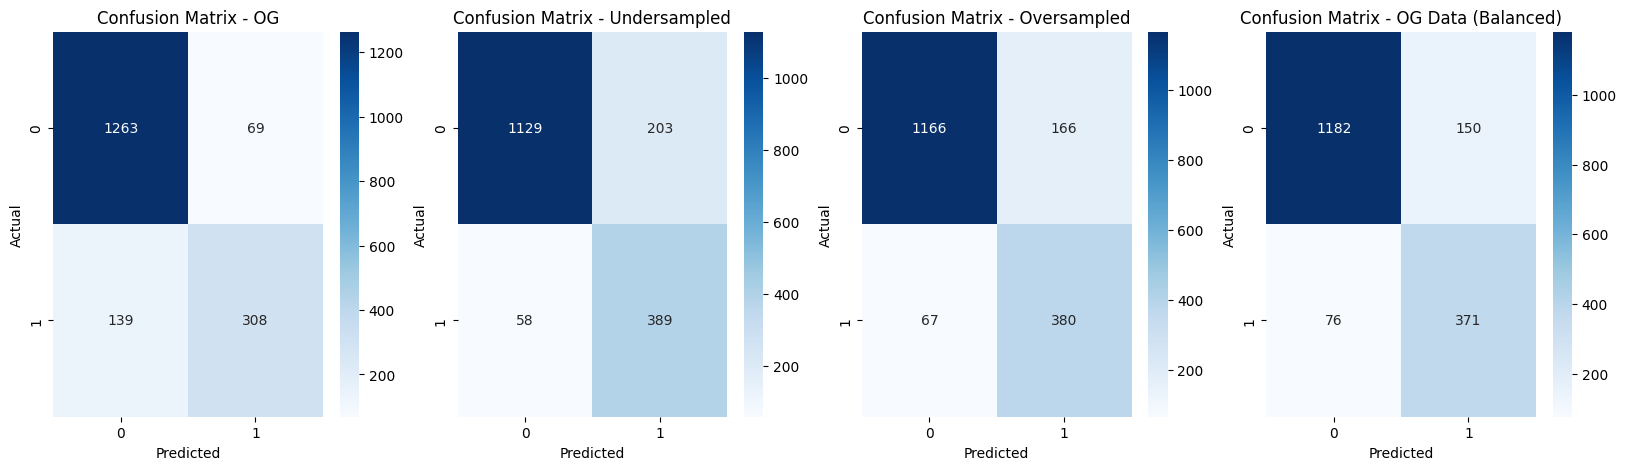

<Figure size 800x600 with 0 Axes>

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# OG
cm_og = confusion_matrix(y_val_og, y_val_pred_og)
sns.heatmap(cm_og, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Confusion Matrix - OG")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

# UNDER
cm_under = confusion_matrix(y_val_under, y_val_pred_under)
sns.heatmap(cm_under, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Confusion Matrix - Undersampled")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

# OVER
cm_over = confusion_matrix(y_val_over, y_val_pred_over)
sns.heatmap(cm_over, annot=True, fmt="d", cmap="Blues", ax=axs[2])
axs[2].set_title("Confusion Matrix - Oversampled")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("Actual")


cm_og_bal = confusion_matrix(y_val_og, y_val_pred_og_bal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_og_bal, annot=True, fmt='d', cmap='Blues', ax=axs[3])
axs[3].set_title("Confusion Matrix - OG Data (Balanced)")
axs[3].set_xlabel("Predicted")
axs[3].set_ylabel("Actual")


plt.tight_layout()
plt.show()

In [28]:
y_test_pred_over = best_model_over.predict(X_test_over)
print(classification_report(y_test_over, y_test_pred_over))

y_test_pred_og_bal = best_model_og_bal.predict(X_test_og)
print(classification_report(y_test_pred_og_bal, y_test_og))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1442
         1.0       0.68      0.89      0.77       534

    accuracy                           0.86      1976
   macro avg       0.82      0.87      0.83      1976
weighted avg       0.88      0.86      0.86      1976

              precision    recall  f1-score   support

         0.0       0.85      0.95      0.90      1290
         1.0       0.89      0.69      0.78       686

    accuracy                           0.86      1976
   macro avg       0.87      0.82      0.84      1976
weighted avg       0.87      0.86      0.86      1976



Text(792.3131313131312, 0.5, 'Actual')

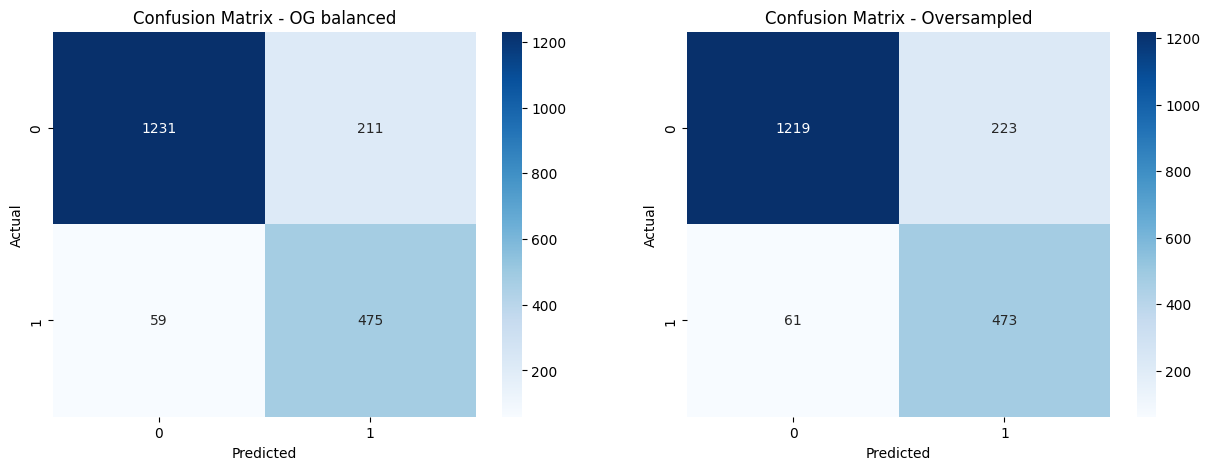

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# UNDER
cm_under = confusion_matrix(y_test_under, y_test_pred_og_bal)
sns.heatmap(cm_under, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Confusion Matrix - OG balanced")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

# OVER
cm_over = confusion_matrix(y_test_over, y_test_pred_over)
sns.heatmap(cm_over, annot=True, fmt="d", cmap="Blues", ax=axs[1])
axs[1].set_title("Confusion Matrix - Oversampled")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

## SVMs

In [31]:
num_nan_rows_og = X_og.isna().any(axis=1).sum()
nan_rows_og = df_filtered_og.isna().any(axis=1).sum()
print(f"Rows with NaN values in X_og: {num_nan_rows_og}")
print(f"Rows with NaN values in df_filtered_og: {nan_rows_og}")

num_nan_rows_under = X_under.isna().any(axis=1).sum()
nan_rows_under = df_filtered_under.isna().any(axis=1).sum()
print(f"Rows with NaN values in X_under: {num_nan_rows_under}")
print(f"Rows with NaN values in df_filtered_under: {nan_rows_under}")

num_nan_rows_over = X_over.isna().any(axis=1).sum()
nan_rows_over = df_filtered_over.isna().any(axis=1).sum()
print(f"Rows with NaN values in X_over: {num_nan_rows_over}")
print(f"Rows with NaN values in df_filtered_over: {nan_rows_over}")

Rows with NaN values in X_og: 0
Rows with NaN values in df_filtered_og: 11
Rows with NaN values in X_under: 0
Rows with NaN values in df_filtered_under: 2
Rows with NaN values in X_over: 0
Rows with NaN values in df_filtered_over: 5


In [32]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid_linear = {'C': [0.01, 0.1, 1, 10]}
tscv = TimeSeriesSplit(n_splits=5)

def train_and_evaluate_svm(X_train, y_train, X_test, y_test, balanced=False):
    svc = LinearSVC(max_iter=10000, random_state=2025, class_weight='balanced' if balanced else None)
    grid_search = GridSearchCV(estimator=svc,
                               param_grid=param_grid_linear,
                               cv=tscv,
                               scoring='f1_macro',
                               verbose=0,
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(np.unique(y_pred, return_counts=True))

    print(f"{'Balanced' if balanced else 'Unbalanced'} SVM Best Params:", grid_search.best_params_)
    print(classification_report(y_test, y_pred))

    return confusion_matrix(y_test, y_pred)

In [33]:
print('OG')
cm_og = train_and_evaluate_svm(X_train_og, y_train_og, X_val_og, y_val_og)
print('UNDER')
cm_under = train_and_evaluate_svm(X_train_under, y_train_under, X_val_under, y_val_under)
print('OVER')
cm_over = train_and_evaluate_svm(X_train_over, y_train_over, X_val_over, y_val_over)

print("\n--- WITH class_weight='balanced' ---\n")
cm_og_bal = train_and_evaluate_svm(X_train_og, y_train_og, X_test_og, y_test_og, balanced=True)

OG
(array([0., 1.]), array([1389,  390]))
Unbalanced SVM Best Params: {'C': 1}
              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1332
         1.0       0.69      0.60      0.64       447

    accuracy                           0.83      1779
   macro avg       0.78      0.75      0.76      1779
weighted avg       0.82      0.83      0.83      1779

UNDER


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
8 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_classes.py", line 321, in fit
    self.coef_, self.intercept_, n_iter

(array([0., 1.]), array([1258,  521]))
Unbalanced SVM Best Params: {'C': 0.01}
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83      1332
         1.0       0.50      0.58      0.54       447

    accuracy                           0.75      1779
   macro avg       0.68      0.69      0.68      1779
weighted avg       0.76      0.75      0.76      1779

OVER
(array([0., 1.]), array([1190,  589]))
Unbalanced SVM Best Params: {'C': 10}
              precision    recall  f1-score   support

         0.0       0.88      0.79      0.83      1332
         1.0       0.52      0.68      0.59       447

    accuracy                           0.76      1779
   macro avg       0.70      0.73      0.71      1779
weighted avg       0.79      0.76      0.77      1779


--- WITH class_weight='balanced' ---

(array([0., 1.]), array([1284,  692]))
Balanced SVM Best Params: {'C': 0.01}
              precision    recall  f1-score   support

         0.0  

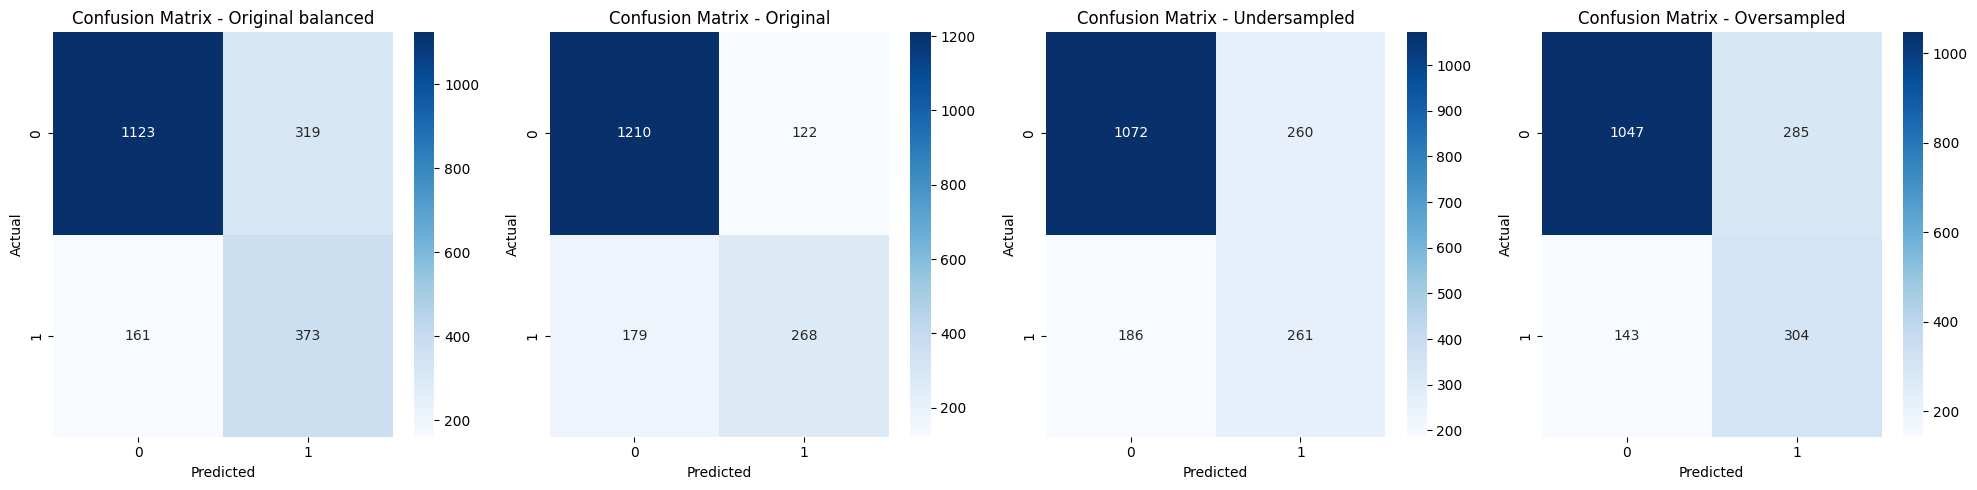

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
titles = ['Original balanced', 'Original', 'Undersampled', 'Oversampled']
cms = [cm_og_bal, cm_og, cm_under, cm_over]
axs = axs.flatten()
for ax, cm, title in zip(axs, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [35]:
svc = LinearSVC(C=1, max_iter=10000, random_state=2025)
svc.fit(X_train_under, y_train_under)
y_pred_under = svc.predict(X_test_under)
print(classification_report(y_test_under, y_pred_under))

              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82      1442
         1.0       0.52      0.61      0.56       534

    accuracy                           0.74      1976
   macro avg       0.68      0.70      0.69      1976
weighted avg       0.76      0.74      0.75      1976



In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

param_grid_rbf = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001]
}

tscv = TimeSeriesSplit(n_splits=5)

In [37]:
print("\n===== OG DATA (with class_weight='balanced') =====")
rbf_svc_og = SVC(kernel='rbf', class_weight='balanced', random_state=2025)
grid_search_rbf_og = GridSearchCV(estimator=rbf_svc_og,
                                  param_grid=param_grid_rbf,
                                  cv=tscv,
                                  scoring='f1_macro',
                                  verbose=1,
                                  n_jobs=-1)
grid_search_rbf_og.fit(X_train_og, y_train_og)
print("Best Parameters (OG):", grid_search_rbf_og.best_params_)
best_rbf_svm_og = grid_search_rbf_og.best_estimator_
y_pred_rbf_og = best_rbf_svm_og.predict(X_val_og)
print(classification_report(y_val_og, y_pred_rbf_og))
cm_og = confusion_matrix(y_val_og, y_pred_rbf_og)
print("\n===== UNDERSAMPLED DATA =====")
rbf_svc_under = SVC(kernel='rbf', random_state=2025)
grid_search_rbf_under = GridSearchCV(estimator=rbf_svc_under,
                                     param_grid=param_grid_rbf,
                                     cv=tscv,
                                     scoring='f1_macro',
                                     verbose=1,
                                     n_jobs=-1)
grid_search_rbf_under.fit(X_train_under, y_train_under)
print("Best Parameters (UNDER):", grid_search_rbf_under.best_params_)
best_rbf_svm_under = grid_search_rbf_under.best_estimator_
y_pred_rbf_under = best_rbf_svm_under.predict(X_val_under)
print(classification_report(y_val_under, y_pred_rbf_under))
cm_under = confusion_matrix(y_val_under, y_pred_rbf_under)
print("\n===== OVERSAMPLED DATA =====")
rbf_svc_over = SVC(kernel='rbf', random_state=2025)
grid_search_rbf_over = GridSearchCV(estimator=rbf_svc_over,
                                    param_grid=param_grid_rbf,
                                    cv=tscv,
                                    scoring='f1_macro',
                                    verbose=1,
                                    n_jobs=-1)
grid_search_rbf_over.fit(X_train_over, y_train_over)
print("Best Parameters (OVER):", grid_search_rbf_over.best_params_)
best_rbf_svm_over = grid_search_rbf_over.best_estimator_
y_pred_rbf_over = best_rbf_svm_over.predict(X_val_over)
print(classification_report(y_val_over, y_pred_rbf_over))
cm_over = confusion_matrix(y_val_over, y_pred_rbf_over)


===== OG DATA (with class_weight='balanced') =====
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters (OG): {'C': 10, 'gamma': 0.001}
              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      1332
         1.0       0.53      0.79      0.63       447

    accuracy                           0.77      1779
   macro avg       0.72      0.77      0.73      1779
weighted avg       0.82      0.77      0.78      1779


===== UNDERSAMPLED DATA =====
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
18 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py", line 207, in fit
    y = self._validate_targets(y)
      

Best Parameters (UNDER): {'C': 0.1, 'gamma': 'scale'}
              precision    recall  f1-score   support

         0.0       0.75      0.01      0.01      1332
         1.0       0.25      0.99      0.40       447

    accuracy                           0.25      1779
   macro avg       0.50      0.50      0.21      1779
weighted avg       0.62      0.25      0.11      1779


===== OVERSAMPLED DATA =====
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters (OVER): {'C': 10, 'gamma': 0.01}
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1332
         1.0       0.55      0.58      0.57       447

    accuracy                           0.78      1779
   macro avg       0.70      0.71      0.71      1779
weighted avg       0.78      0.78      0.78      1779



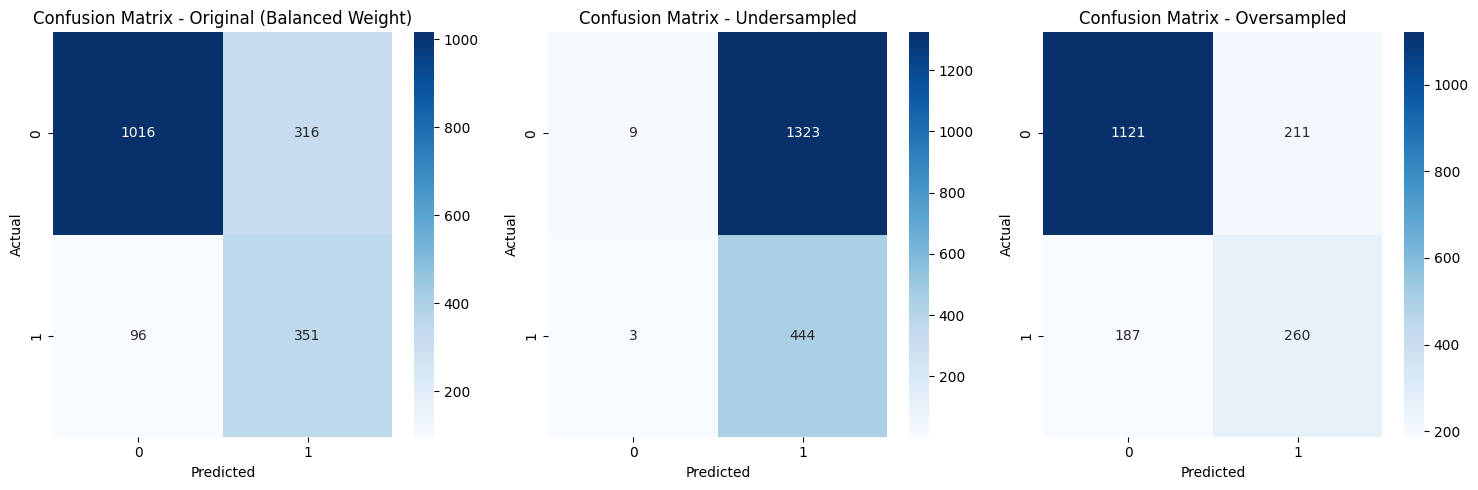

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
titles = ['Original (Balanced Weight)', 'Undersampled', 'Oversampled']
cms = [cm_og, cm_under, cm_over]

for ax, cm, title in zip(axs, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix - {title}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [39]:
print("\n===== OVERSAMPLED DATA =====")
y_pred_rbf_over = best_rbf_svm_over.predict(X_test_over)
print(classification_report(y_test_over, y_pred_rbf_over))
cm_over = confusion_matrix(y_test_over, y_pred_rbf_over)


===== OVERSAMPLED DATA =====
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      1442
         1.0       0.59      0.65      0.62       534

    accuracy                           0.79      1976
   macro avg       0.73      0.74      0.74      1976
weighted avg       0.79      0.79      0.79      1976



## KNN & logreg (helena)

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.utils.class_weight import compute_sample_weight

In [41]:
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

def get_pipeline():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

In [42]:
def run_knn(X_train, y_train, X_test, y_test, label=''):
    pipe = get_pipeline()
    grid_search = GridSearchCV(pipe, param_grid_knn, cv=tscv, scoring='f1_macro', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"\nBest KNN Parameters ({label}): {grid_search.best_params_}")
    y_pred = grid_search.predict(X_test)
    print(f"\nKNN Results ({label}):")
    print(classification_report(y_test, y_pred))
    return confusion_matrix(y_test, y_pred)

In [43]:
print("=== Original Dataset - Unbalanced ===")
cm_og_unbalanced = run_knn(X_train_og, y_train_og, X_val_og, y_val_og, label='Original - Unbalanced')

print("\n=== Original Dataset - Balanced (via same data, no resampling) ===")
cm_og_balanced = run_knn(X_train_og, y_train_og, X_val_og, y_val_og, label='Original - Balanced')

print("\n=== Undersampled Dataset ===")
cm_under = run_knn(X_train_under, y_train_under, X_val_under, y_val_under, label='Undersampled')

print("\n=== Oversampled Dataset ===")
cm_over = run_knn(X_train_over, y_train_over, X_val_over, y_val_over, label='Oversampled')

=== Original Dataset - Unbalanced ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best KNN Parameters (Original - Unbalanced): {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}

KNN Results (Original - Unbalanced):
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      1332
         1.0       0.74      0.76      0.75       447

    accuracy                           0.87      1779
   macro avg       0.83      0.84      0.83      1779
weighted avg       0.87      0.87      0.87      1779


=== Original Dataset - Balanced (via same data, no resampling) ===
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best KNN Parameters (Original - Balanced): {'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}

KNN Results (Original - Balanced):
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92      1332
         1.0

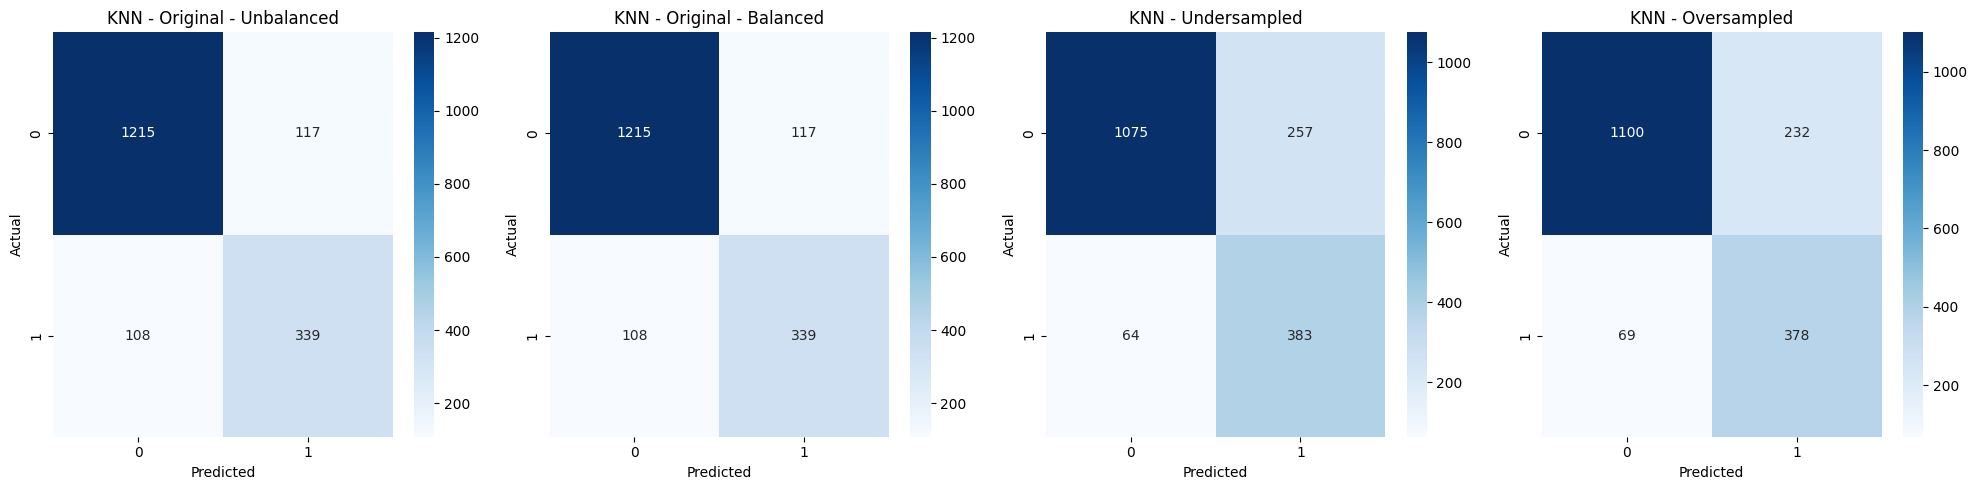

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
cms = [cm_og_unbalanced, cm_og_balanced, cm_under, cm_over]
titles = ['Original - Unbalanced', 'Original - Balanced', 'Undersampled', 'Oversampled']

for ax, cm, title in zip(axs.flat, cms, titles):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"KNN - {title}")
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

In [45]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(
            metric='manhattan',
            n_neighbors=9,
            weights='distance'
        ))
    ])
pipe.fit(X_train_over, y_train_over)
y_pred_over = pipe.predict(X_test_over)

print(f"\nKNN Results (metric=manhattan, n_neighbors=9, weights=distance):")
print(classification_report(y_test_over, y_pred_over))


KNN Results (metric=manhattan, n_neighbors=9, weights=distance):
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87      1442
         1.0       0.62      0.86      0.72       534

    accuracy                           0.82      1976
   macro avg       0.78      0.83      0.80      1976
weighted avg       0.85      0.82      0.83      1976



In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}


print("\n===== Logistic Regression - Original Data =====")

lr_og = LogisticRegression(random_state=2025)
grid_search_og = GridSearchCV(estimator=lr_og,
                              param_grid=param_grid_lr,
                              cv=tscv,
                              scoring='f1_macro',
                              verbose=1,
                              n_jobs=-1)
grid_search_og.fit(X_train_og, y_train_og)

print("OG Best Parameters (Unbalanced):", grid_search_og.best_params_)
best_lr_og = grid_search_og.best_estimator_
y_pred_lr_og = best_lr_og.predict(X_val_og)
print("Logistic Regression (Unbalanced) Results:")
print(classification_report(y_val_og, y_pred_lr_og))

lr_og_bal = LogisticRegression(random_state=2025, class_weight='balanced')
grid_search_og_bal = GridSearchCV(estimator=lr_og_bal,
                                  param_grid=param_grid_lr,
                                  cv=tscv,
                                  scoring='f1_macro',
                                  verbose=1,
                                  n_jobs=-1)
grid_search_og_bal.fit(X_train_og, y_train_og)

print("OG Best Parameters (Balanced):", grid_search_og_bal.best_params_)
best_lr_og_bal = grid_search_og_bal.best_estimator_
y_pred_lr_og_bal = best_lr_og_bal.predict(X_val_og)
print("Logistic Regression (Balanced) Results:")
print(classification_report(y_val_og, y_pred_lr_og_bal))

print("\n===== Logistic Regression - Undersampled Data =====")
lr_under = LogisticRegression(random_state=2025)
grid_search_under = GridSearchCV(estimator=lr_under,
                                 param_grid=param_grid_lr,
                                 cv=tscv,
                                 scoring='f1_macro',
                                 verbose=1,
                                 n_jobs=-1)
grid_search_under.fit(X_train_under, y_train_under)

print("Under Best Parameters (Unbalanced):", grid_search_under.best_params_)
best_lr_under = grid_search_under.best_estimator_
y_pred_lr_under = best_lr_under.predict(X_val_under)
print("Logistic Regression (Undersampled) Results:")
print(classification_report(y_val_under, y_pred_lr_under))

print("\n===== Logistic Regression - Oversampled Data =====")
lr_over = LogisticRegression(random_state=2025)
grid_search_over = GridSearchCV(estimator=lr_over,
                                param_grid=param_grid_lr,
                                cv=tscv,
                                scoring='f1_macro',
                                verbose=1,
                                n_jobs=-1)
grid_search_over.fit(X_train_over, y_train_over)

print("Over Best Parameters (Unbalanced):", grid_search_over.best_params_)
best_lr_over = grid_search_over.best_estimator_
y_pred_lr_over = best_lr_over.predict(X_val_over)
print("Logistic Regression (Oversampled) Results:")
print(classification_report(y_val_over, y_pred_lr_over))


===== Logistic Regression - Original Data =====
Fitting 5 folds for each of 3 candidates, totalling 15 fits
OG Best Parameters (Unbalanced): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression (Unbalanced) Results:
              precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      1332
         1.0       0.67      0.51      0.58       447

    accuracy                           0.81      1779
   macro avg       0.76      0.71      0.73      1779
weighted avg       0.80      0.81      0.81      1779

Fitting 5 folds for each of 3 candidates, totalling 15 fits
OG Best Parameters (Balanced): {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression (Balanced) Results:
              precision    recall  f1-score   support

         0.0       0.91      0.80      0.85      1332
         1.0       0.55      0.76      0.64       447

    accuracy                           0.79      1779
   macro avg       0.73      0.78      0

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
6 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1276, in fit
    self.coef_, self.interce

Under Best Parameters (Unbalanced): {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression (Undersampled) Results:
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82      1332
         1.0       0.50      0.77      0.61       447

    accuracy                           0.75      1779
   macro avg       0.70      0.76      0.71      1779
weighted avg       0.80      0.75      0.76      1779


===== Logistic Regression - Oversampled Data =====
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Over Best Parameters (Unbalanced): {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression (Oversampled) Results:
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82      1332
         1.0       0.49      0.58      0.53       447

    accuracy                           0.74      1779
   macro avg       0.67      0.69      0.68      1779
weighted avg       0.76      0.

In [47]:
y_pred_lr_under = best_lr_under.predict(X_test_under)
print("Logistic Regression (Undersampled) Results:")
print(classification_report(y_test_under, y_pred_lr_under))

Logistic Regression (Undersampled) Results:
              precision    recall  f1-score   support

         0.0       0.90      0.72      0.80      1442
         1.0       0.51      0.78      0.62       534

    accuracy                           0.74      1976
   macro avg       0.71      0.75      0.71      1976
weighted avg       0.80      0.74      0.75      1976



# Logistic Regression
Classifier that will let us see how pre-ignition features impact the odd of human or lightning.


In [48]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [49]:
dff = df_filtered.copy()
dff.loc[:, 'Ign_DateTime'] = pd.to_datetime(dff['Ign_DateTime'], errors='coerce')
dff.loc[:, 'Ign_Year']    = dff['Ign_DateTime'].dt.year
dff.loc[:, 'Ign_Month']   = dff['Ign_DateTime'].dt.month
dff = dff.dropna()

NameError: name 'df_filtered' is not defined

In [ ]:

y = dff['HumanOrLightning_encoded']
X = df_filtered_nan.drop(columns=[
    'HumanOrLightning',               # original label
    'HumanOrLightning_encoded',       # target (keep it out of features)
    'LatLongDD',                      # duplicate of Lat + Long
    'Ign_DateTime',                   # raw datetime
    'Control_DateTime',               # raw datetime
    'Size_class',
    'CauseBy_Fisherman', 'CauseBy_Hiker', 'CauseBy_Hunter',
    'CauseBy_Lightning', 'CauseBy_Marijuana Grower', 'CauseBy_Motorist',
       'CauseBy_Other Forest Mgt. Worker', 'CauseBy_Other-Landowner Related',
       'CauseBy_Other-Public', 'CauseBy_Public Utility',
       'CauseBy_Rancher-Farmer', 'CauseBy_Recreationist',
       'CauseBy_Ruralist-Non-Paying', 'CauseBy_Ruralist-Paying',
       'CauseBy_Timber Harvest Worker', 'CauseBy_Transient',
       'GeneralCause_Arson', 'GeneralCause_Debris Burning',
       'GeneralCause_Equipment Use', 'GeneralCause_Juveniles',
       'GeneralCause_Lightning', 'GeneralCause_Miscellaneous',
       'GeneralCause_Railroad', 'GeneralCause_Recreation',
       'GeneralCause_Smoking', 'GeneralCause_Under Invest'
])


In [ ]:
X.columns

In [ ]:
# Drop any columns of dtype timedelta
td_cols = X.select_dtypes(include=['timedelta64']).columns.tolist()
print("Dropping timedelta cols:", td_cols)
X = X.drop(columns=td_cols)
X = X.astype(float)

In [ ]:
numeric_feats = X.columns.tolist()
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_feats),
], remainder='passthrough')  # one‑hots pass through

pipeline = Pipeline([
    # fill any NaNs with the median of each column
    ('imputer', SimpleImputer(strategy='median')),
    # standardize every feature to mean=0, std=1
    ('scaler',  StandardScaler()),
    # your logistic regression model
    ('model',   LogisticRegression(max_iter=1000, random_state=42))
])

In [ ]:
#split based on year
cutoff_year = df_filtered['Ign_Year'].max() - 2   # e.g. last 2 years held out
train_mask = df_filtered['Ign_Year'] <= cutoff_year
test_mask  = df_filtered['Ign_Year'] >  cutoff_year

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_test,  y_test  = X.loc[test_mask],  y.loc[test_mask]

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
    ('model',   LogisticRegression(max_iter=1000, random_state=42))
])

pipeline.fit(X_train, y_train)
print("Held‑out accuracy:", pipeline.score(X_test, y_test))

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("=== Hold‑Out by Year Test ===")
print(f"Years trained: ≤{cutoff_year}, tested: >{cutoff_year}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

full_idx = df['Ign_DateTime'].sort_values().index

sorted_idx = full_idx.intersection(X.index)


X_sorted = X.loc[sorted_idx]
y_sorted = y.loc[sorted_idx]


tscv = TimeSeriesSplit(n_splits=5)
scores = []

print("\n=== TimeSeriesSplit CV Scores ===")
for fold, (train_ix, test_ix) in enumerate(tscv.split(X_sorted), start=1):
    X_tr, y_tr = X_sorted.iloc[train_ix], y_sorted.iloc[train_ix]
    X_te, y_te = X_sorted.iloc[test_ix],  y_sorted.iloc[test_ix]

    pipeline.fit(X_tr, y_tr)
    acc = pipeline.score(X_te, y_te)
    scores.append(acc)
    print(f" Fold {fold}: Accuracy = {acc:.3f}")

print(f"\nMean accuracy: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


The linear model correctly identifies about 80% of fires as human-or lightning-ignited based on information.






# K Nearest Neigbhors
Classifier that will let us see INSERT

In [ ]:
from sklearn.model_selection import train_test_split

knn_set = df_filtered.dropna()

y = knn_set['HumanOrLightning_encoded']

X = knn_set.drop(columns=[
    'HumanOrLightning',               # original label
    'HumanOrLightning_encoded',       # target (keep it out of features)
    'LatLongDD',                      # duplicate of Lat + Long
    'Ign_DateTime',                   # raw datetime
    'Control_DateTime',               # raw datetime
    'Size_class',                     #NaN
    'Area_EOA',                       #NaN
    'Area_NOA',                       #NaN
    'Area_SOA',                       #NaN
    'LandType_Agriculture',           #NaN
    'GeneralCause_Lightning',         #NaN
    'GeneralCause_Miscellaneous',     #NaN
    'GeneralCause_Railroad',          #NaN
    'GeneralCause_Recreation',        #NaN
    'GeneralCause_Smoking',           #NaN
    'LandType_BIA',                   #NaN
    'LandType_BLM',                   #NaN
    'LandType_ERROR: #N/A',           #NaN
    'LandType_State',                 #NaN
    'LandType_Industrial',            #NaN
    'LandType_Other Private',         #NaN
    'LandType_Other Public',          #NaN
    'LandType_Rural Residential',     #NaN
    'LandType_Small Woodlands',       #NaN
    'LandType_USFS',                  #NaN
    'LandType_Municipal',             #NaN
    'LandType_Ocean Shores',          #NaN
    'LandType_County',                #NaN
    'DistrictName_Astoria',           #NaN
    'DistrictName_Central Oregon',    #NaN
    'DistrictName_Tillamook',         #NaN
    'DistrictName_Walker Range - WRFPA', #NaN
    'DistrictName_West Oregon',       #NaN
    'DistrictName_Coos - CFPA',       #NaN
    'DistrictName_Douglas - DFPA',    #NaN
    'DistrictName_Forest Grove',      #NaN
    'DistrictName_Klamath-Lake',      #NaN
    'DistrictName_North Cascade',     #NaN
    'DistrictName_Northeast Oregon',  #NaN
    'DistrictName_South Cascade',     #NaN
    'DistrictName_Southwest Oregon',  #NaN
    'DistrictName_Western Lane',      #NaN
    'CauseBy_Fisherman',              #NaN
    'CauseBy_Hunter',                 #NaN
    'CauseBy_Hiker',                  #NaN
    'CauseBy_Lightning',              #NaN
    'CauseBy_Marijuana Grower',       #NaN
    'CauseBy_Motorist',               #NaN
    'CauseBy_Other Forest Mgt. Worker', #NaN
    'CauseBy_Other-Landowner Related', #NaN
    'CauseBy_Timber Harvest Worker',  #NaN
    'CauseBy_Transient',              #NaN
    'CauseBy_Other-Public',           #NaN
    'CauseBy_Public Utility',         #NaN
    'CauseBy_Rancher-Farmer',         #NaN
    'CauseBy_Recreationist',          #NaN
    'CauseBy_Ruralist-Non-Paying',    #NaN
    'CauseBy_Ruralist-Paying',        #NaN
    'GeneralCause_Arson',             #NaN
    'GeneralCause_Debris Burning',    #NaN
    'GeneralCause_Equipment Use',     #NaN
    'GeneralCause_Juveniles',         #NaN
    'GeneralCause_Under Invest'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2025,
                 stratify = y)

print(X)

print(X_train.shape)
print(X_test.shape)
X_train.head(5)

scatter_plot_df = X_train[['FireYear','EstTotalAcres',
                           'Protected_Acres','Lat_DD','Long_DD',
  'Size_class_encoded','Ign_Month','Time_Difference',
  'Control_Minutes']].copy()

scatter_plot_df['target'] = y_train

sns.set(font_scale=2)
sns.pairplot(data= scatter_plot_df, hue = 'target', height=2)
plt.show()

In [ ]:
plt.figure(figsize=(12,12))
cm = X_train.corr()
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cbar = True , annot=True, square=True, fmt='.1f',
                 xticklabels=X_train.columns, yticklabels= X_train.columns)

#correlate with output HumanOrLightning
plt.show()

In [ ]:
y_train = np.array(X_train)
X_train = np.array(X_train)

y_test = np.array(X_test)
X_test = np.array(X_test)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k_neighbors = 10
dist = 'euclidean'

my_knn = KNeighborsClassifier(n_neighbors = k_neighbors, metric = dist)
my_knn.fit(X_train,y_train)

print('Prediction accuracy on training set:', np.round(my_knn.score(X_train, y_train),4))

In [ ]:
y_train #check y_train